<a href="https://colab.research.google.com/github/velu1507/predictive-analytics-for-mastitis-and-cattle-health-with-IoT-driven-detectors/blob/main/cow_health.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving cow_data.csv to cow_data.csv


In [ ]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic

# Constants
center_point = (9.957890, 77.991337)
radius = 0.004  # approx 400 meters in latitude/longitude

# Load dataset
df = pd.read_csv('cow_data.csv')

# Function to classify activity based on distance from center point
def classify_activity(row):
    cow_point = (row['latitude'], row['longitude'])
    distance = geodesic(center_point, cow_point).meters
    if distance <= 400:
        return 'eating'
    else:
        return 'resting'

# Apply activity classification
df['activity'] = df.apply(classify_activity, axis=1)


df['status'] = 'healthy'

# Function to check for status based on conditions
def check_mastitis(subset):
    resting_hours = subset[subset['activity'] == 'resting']
    if len(resting_hours) > 7:
        temp_exceed = resting_hours['temperature'].gt(38.3).rolling(window=2).sum()
        if any(temp_exceed >= 2):
            return 'abnormal'
    return 'healthy'

# Group by cow_id and date to apply mastitis check
for (cow_id, date), group in df.groupby(['cow_id', 'date']):
    df.loc[(df['cow_id'] == cow_id) & (df['date'] == date), 'status'] = check_mastitis(group)

# Save updated DataFrame with activity and mastitis columns
df.to_csv('cow_tracking_data_with_activity_mastitis1.csv', index=False)


In [ ]:
from google.colab import files

# Trigger the download
files.download('cow_tracking_data_with_activity_mastitis1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd

# Load the dataset with mastitis and activity status
df = pd.read_csv('cow_tracking_data_with_activity_mastitis1.csv')

# Group by cow_id and filter for days with "mastitis expected" status
abnormal_days = df[df['status'] == 'abnormal'].groupby('cow_id')['date'].nunique()

# Create a summary DataFrame for mastitis status per cow_id
mastitis_summary = []
for cow_id in df['cow_id'].unique():
    if abnormal_days.get(cow_id, 0) > 4:
        mastitis_summary.append({'cow_id': cow_id, 'mastitis': 'mastitis detected'})
    else:
        mastitis_summary.append({'cow_id': cow_id, 'mastitis': 'healthy'})

# Convert to DataFrame
summary_df = pd.DataFrame(mastitis_summary)

# Save the result to a new CSV file
summary_df.to_csv('cow_mastitis_status_summary.csv', index=False)


In [ ]:
from google.colab import files



# Trigger the download
files.download('cow_mastitis_status_summary.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
from geopy.distance import geodesic

# Load the datasets
tracking_df = pd.read_csv('cow_tracking_data_with_activity_mastitis1.csv')
mastitis_status_df = pd.read_csv('cow_mastitis_status_summary.csv')

# Identify cow_ids with "mastitis detected"
mastitis_cows = mastitis_status_df[mastitis_status_df['mastitis'] == 'mastitis detected']['cow_id'].tolist()

# Create new columns in the tracking DataFrame
tracking_df['distance'] = np.nan
tracking_df['probability'] = 0

# Calculate distances from each "mastitis detected" cow to other cows and update probability
for mastitis_cow_id in mastitis_cows:
    # Get the subset of data for the mastitis cow
    mastitis_cow_data = tracking_df[tracking_df['cow_id'] == mastitis_cow_id]

    # For each time and date, calculate distance to all other cows
    for _, mastitis_row in mastitis_cow_data.iterrows():
        center_point = (mastitis_row['latitude'], mastitis_row['longitude'])
        date, time = mastitis_row['date'], mastitis_row['time']

        # Get all other cows' data for the same date and time
        other_cows_data = tracking_df[(tracking_df['date'] == date) & (tracking_df['time'] == time) & (tracking_df['cow_id'] != mastitis_cow_id)]

        # Calculate distance and set probability
        for idx, other_row in other_cows_data.iterrows():
            other_point = (other_row['latitude'], other_row['longitude'])
            distance = geodesic(center_point, other_point).meters
            tracking_df.at[idx, 'distance'] = distance
            tracking_df.at[idx, 'probability'] = 1 if distance <= 300 else 0

# Calculate risk level based on probability for each cow and date
risk_levels = []
for (cow_id, date), group in tracking_df.groupby(['cow_id', 'date']):
    hours_in_contact = group['probability'].sum()
    if hours_in_contact > 8:
        risk = 'high'
    elif 4 < hours_in_contact <= 8:
        risk = 'medium'
    else:
        risk = 'low'
    risk_levels.append({'cow_id': cow_id, 'date': date, 'risk': risk})

# Create a DataFrame for the risk levels and merge it back to the original tracking DataFrame
risk_df = pd.DataFrame(risk_levels)
tracking_df = tracking_df.merge(risk_df, on=['cow_id', 'date'], how='left')

# Save the updated dataset with distance, probability, and risk columns
tracking_df.to_csv('cow_tracking_data_with_risk.csv', index=False)


In [ ]:
from google.colab import files

# Trigger the download
files.download('cow_tracking_data_with_risk.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd

# Load the risk data and mastitis summary dataset
tracking_df = pd.read_csv('cow_tracking_data_with_risk.csv')
mastitis_status_df = pd.read_csv('cow_mastitis_status_summary.csv')

# Count the number of "medium" risk days for each cow
medium_risk_days = tracking_df[tracking_df['risk'] == 'medium'].groupby('cow_id')['date'].nunique()

# Create a new column 'expected mastitis' based on the medium-risk count
mastitis_status_df['expected mastitis'] = mastitis_status_df['cow_id'].apply(
    lambda cow_id: 'medium-risk' if medium_risk_days.get(cow_id, 0) > 2 else 'low-risk'
)

# Save the updated mastitis status dataset with the new column
mastitis_status_df.to_csv('cow_mastitis_status_summary_updated.csv', index=False)


In [ ]:
from google.colab import files

# Trigger the download
files.download('cow_mastitis_status_summary_updated.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pip install pandas numpy scikit-learn xgboost tensorflow geopy


In [ ]:
!pip install xgboost lightgbm



/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:12:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:12:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:12:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboo

[LightGBM] [Info] Number of positive: 214, number of negative: 867
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 509
[LightGBM] [Info] Number of data points in the train set: 1081, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197965 -> initscore=-1.399063
[LightGBM] [Info] Start training from score -1.399063
[LightGBM] [Info] Number of positive: 214, number of negative: 867
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 508
[LightGBM] [Info] Number of data points in the train set: 1081, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197965 -> initscore=-1.399063
[LightGBM] [Info

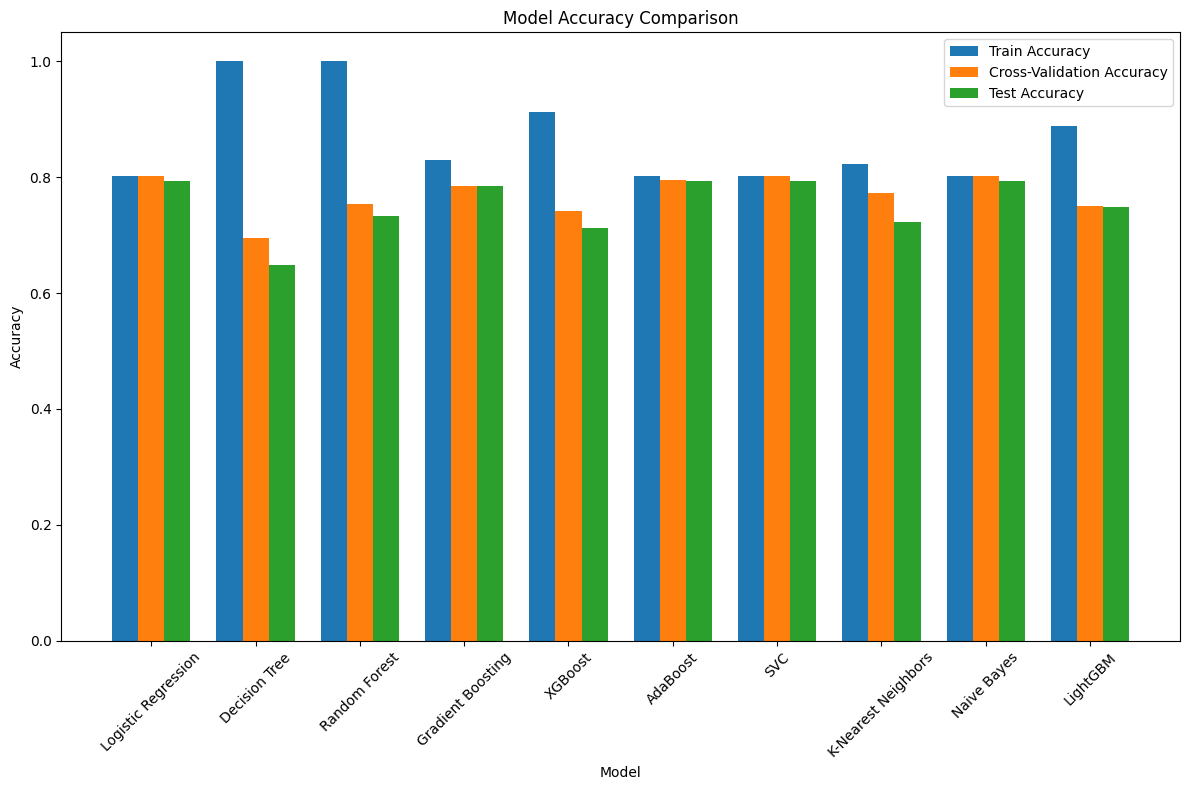

Accuracy plot saved as 'model_accuracy_comparison.png'.


<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer # Import SimpleImputer for handling missing values


# Load and combine datasets
tracking_df = pd.read_csv('cow_tracking_data_with_risk.csv')
mastitis_status_df = pd.read_csv('cow_mastitis_status_summary_updated.csv')

# Merge datasets on cow_id to align features with target label
df = pd.merge(tracking_df, mastitis_status_df[['cow_id', 'expected mastitis']], on='cow_id', how='left')

# Feature engineering - selecting relevant features and target variable
features = ['distance', 'probability', 'temperature']  # Add more features if available
target = 'expected mastitis'

# Encode target and categorical features if any
label_encoder = LabelEncoder()
df[target] = label_encoder.fit_transform(df[target])  # Encode 'expected mastitis'

# Splitting data into training and testing sets
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Impute missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')  # Replace 'mean' with other strategies if needed
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)


# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the classifiers
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "AdaBoost": AdaBoostClassifier(),
    "SVC": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "LightGBM": LGBMClassifier()
}

# Train and evaluate each model
# Train and evaluate each model
results = []
for name, model in models.items():
    # Cross-validation for accuracy
    cross_val_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cross_val_accuracy = np.mean(cross_val_scores)

    # Training the model
    model.fit(X_train, y_train)

    # Predictions on training data (for training accuracy)
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    # Predictions on test data (for test accuracy)
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Store the results
    results.append({
        "Model": name,
        "Train Accuracy": train_accuracy,
        "Cross-Validation Accuracy": cross_val_accuracy,
        "Test Accuracy": test_accuracy
    })

# Convert results to a DataFrame and display as a table
results_df = pd.DataFrame(results)
print("Model Accuracy Analysis")
print(results_df)
# Save the tabular column (accuracy analysis) as a CSV file
results_df.to_csv('model_accuracy_analysis.csv', index=False)
print("Accuracy table saved as 'model_accuracy_analysis.csv'.")
# Plotting accuracies in a bar chart
plt.figure(figsize=(12, 8))
bar_width = 0.25
index = np.arange(len(results_df))

# Training, Cross-Validation, and Test accuracy bars
plt.bar(index, results_df['Train Accuracy'], bar_width, label='Train Accuracy')
plt.bar(index + bar_width, results_df['Cross-Validation Accuracy'], bar_width, label='Cross-Validation Accuracy')
plt.bar(index + 2 * bar_width, results_df['Test Accuracy'], bar_width, label='Test Accuracy')

# Adding labels and title
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(index + bar_width, results_df['Model'], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()
plt.savefig('model_accuracy_comparison.png')
print("Accuracy plot saved as 'model_accuracy_comparison.png'.")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Load the datasets
tracking_df = pd.read_csv('cow_tracking_data_with_risk.csv')
mastitis_status_df = pd.read_csv('cow_mastitis_status_summary_updated.csv')

# Merge datasets on cow_id and date
merged_df = pd.merge(tracking_df, mastitis_status_df[['cow_id', 'expected mastitis']], on='cow_id', how='left')

# Feature Engineering
# Generate daily aggregated features: total hours of "resting" and "eating", max distance, avg temp, etc.
aggregated_df = merged_df.groupby(['cow_id', 'date']).agg({
    'probability': 'sum',                     # Daily total probability
    'temperature': ['mean', 'max'],           # Average and max daily temperature
    'activity': lambda x: (x == 'resting').sum(),  # Total hours resting
    'distance': 'max'                         # Max daily distance from "mastitis detected" cows
}).reset_index()

# Rename columns
aggregated_df.columns = ['cow_id', 'date', 'total_probability', 'avg_temp', 'max_temp', 'total_resting_hours', 'max_distance']

# Merge the target label (expected mastitis) back to the aggregated data
final_df = pd.merge(aggregated_df, mastitis_status_df[['cow_id', 'expected mastitis']], on='cow_id', how='left')
final_df['target'] = final_df['expected mastitis'].apply(lambda x: 1 if x == 'medium-risk' else 0)

# Split data into features (X) and target (y)
X = final_df[['total_probability', 'avg_temp', 'max_temp', 'total_resting_hours', 'max_distance']]
y = final_df['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data (if needed)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Results dictionary
results = {}

# 1. Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
results['Random Forest'] = accuracy_score(y_test, y_pred_rf)

# 2. Gradient Boosting (XGBoost)
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
results['Gradient Boosting'] = accuracy_score(y_test, y_pred_xgb)

# Display results
for model_name, accuracy in results.items():
    print(f"{model_name} Accuracy: {accuracy:.2f}")


Random Forest Accuracy: 0.88
Gradient Boosting Accuracy: 0.88


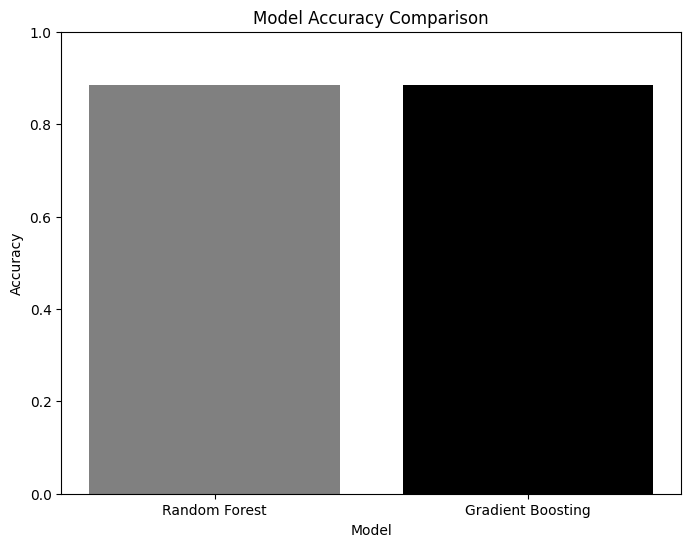

In [ ]:
import matplotlib.pyplot as plt

# Plot model accuracies
model_names = list(results.keys())
accuracy_scores = list(results.values())

plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracy_scores, color=['grey', 'black'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)  # Accuracy range from 0 to 1
plt.show()


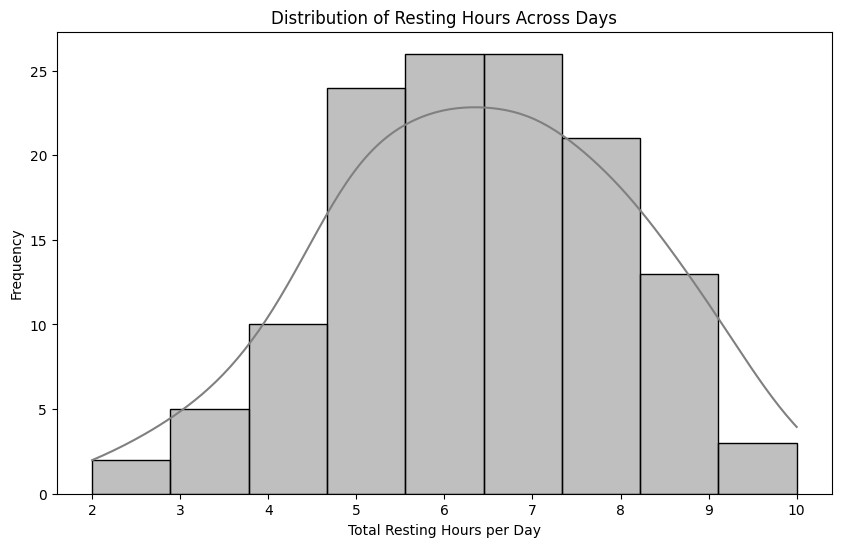

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(final_df['total_resting_hours'], kde=True, color='grey')
plt.xlabel('Total Resting Hours per Day')
plt.ylabel('Frequency')
plt.title('Distribution of Resting Hours Across Days')
plt.show()


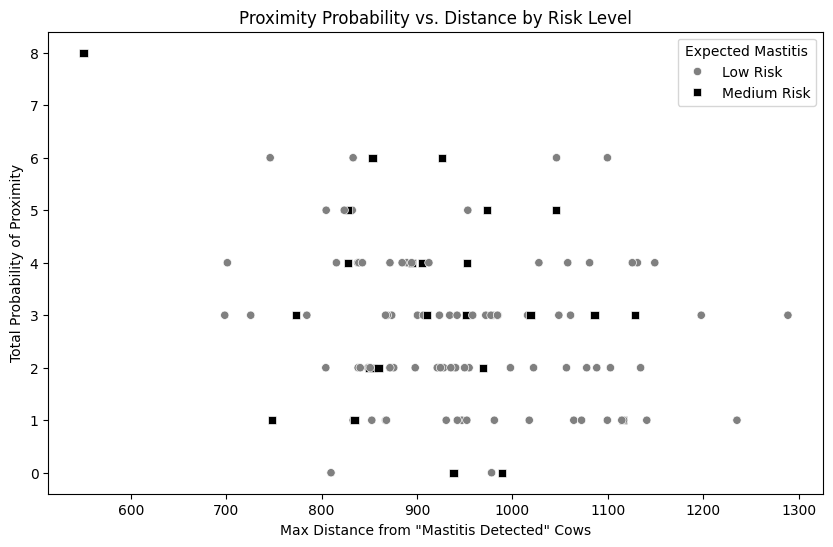

In [ ]:
# Mapping target values to labels for clear legend
final_df['risk_label'] = final_df['target'].map({0: 'Low Risk', 1: 'Medium Risk'})

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=final_df,
    x='max_distance',
    y='total_probability',
    hue='risk_label',         # Use the mapped labels for hue
    palette={'Low Risk': 'grey', 'Medium Risk': 'black'},  # Define colors for each risk level
    style='risk_label',       # Use the same label for style to keep shapes consistent
    markers={'Low Risk': 'o', 'Medium Risk': 's'}            # Different marker shapes
)
plt.xlabel('Max Distance from "Mastitis Detected" Cows')
plt.ylabel('Total Probability of Proximity')
plt.title('Proximity Probability vs. Distance by Risk Level')
plt.legend(title='Expected Mastitis')  # Legend will now correctly show colors and labels
plt.show()



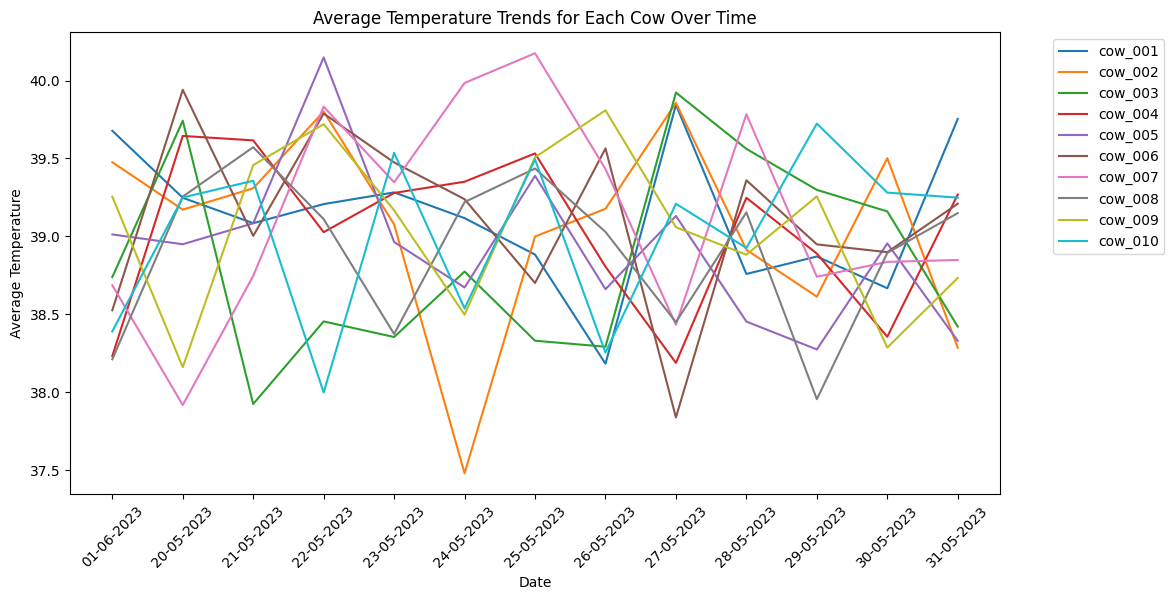

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=final_df, x='date', y='avg_temp', hue='cow_id', palette='tab10')
plt.xlabel('Date')
plt.ylabel('Average Temperature')
plt.title('Average Temperature Trends for Each Cow Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()
